### Load your Libraries


In [1]:
# Common Python Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
import math
import datetime as dt
import os
import logging

In [2]:
# Azure Libaries
from azureml.core import Datastore
from azureml.core.dataset import Dataset
from azureml.core.workspace import Workspace
from azureml.core.authentication import InteractiveLoginAuthentication
from azureml.core.compute import ComputeTarget, AmlCompute
from azureml.core.experiment import Experiment
from azureml.core.environment import Environment
from azureml.core.conda_dependencies import CondaDependencies
from azureml.explain.model._internal.explanation_client import ExplanationClient
from azureml.train.hyperdrive import HyperDriveConfig, PrimaryMetricGoal, BayesianParameterSampling, uniform, choice
from azureml.core import Run
from azureml.train.estimator import Estimator
from azureml.widgets import RunDetails

In [3]:
# XG Boost Libraries
from numpy import loadtxt
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import make_scorer, r2_score, mean_squared_error
from sklearn import metrics
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from xgboost import XGBClassifier
import matplotlib.pylab as plt
from matplotlib import pyplot
from collections import Counter

### Set your Workspace

In [4]:
# Check the base version of AzureMl
import azureml.core
print("You are currently using version " + azureml.core.VERSION + " of the Azure ML SDK")

You are currently using version 1.6.0 of the Azure ML SDK


In [5]:
# Retrieve your workspace
ws = Workspace.from_config()

### Set your Remote Compute Target

In [6]:
# Retrieve your Compute Target for Running AutoML Remotely
compute_name = 'aml-cluster' # CHANGE HERE
compute_target = ComputeTarget(ws, compute_name) 

### Retrieve your Datasets by name



In [7]:
# Retrieve your Datasets by name
df_name  = "auto-mpg-classification-input" # CHANGE HERE


# Load Data in as Tabular Datasets
df_tab  = Dataset.get_by_name(ws, df_name, version='latest')


# Change to pandas dataframe
df = df_tab.to_pandas_dataframe()

In [8]:
df.head()

,Column1,Column2,Column3,Column4,Column5,Column6,Column7,Column8,Column9
0,18.0,8,307.0,130,3504,12.0,70,1,"\t""chevrolet chevelle malibu"""
1,15.0,8,350.0,165,3693,11.5,70,1,"\t""buick skylark 320"""
2,18.0,8,318.0,150,3436,11.0,70,1,"\t""plymouth satellite"""
3,16.0,8,304.0,150,3433,12.0,70,1,"\t""amc rebel sst"""
4,17.0,8,302.0,140,3449,10.5,70,1,"\t""ford torino"""


In [9]:
# get rid of the last column as we dont gain any info from it
df_column9_dropped = df.drop(['Column9'], axis=1)
df_column9_dropped.head()

,Column1,Column2,Column3,Column4,Column5,Column6,Column7,Column8
0,18.0,8,307.0,130,3504,12.0,70,1
1,15.0,8,350.0,165,3693,11.5,70,1
2,18.0,8,318.0,150,3436,11.0,70,1
3,16.0,8,304.0,150,3433,12.0,70,1
4,17.0,8,302.0,140,3449,10.5,70,1


In [10]:
# add header row to the dataframe
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight','Acceleration', 'Model Year', 'Origin']
df_column9_dropped.columns = column_names
df_with_headers = df_column9_dropped
df_with_headers.head()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
0,18.0,8,307.0,130,3504,12.0,70,1
1,15.0,8,350.0,165,3693,11.5,70,1
2,18.0,8,318.0,150,3436,11.0,70,1
3,16.0,8,304.0,150,3433,12.0,70,1
4,17.0,8,302.0,140,3449,10.5,70,1


In [11]:
# remove rows with '?' character

df_with_headers = df_with_headers[df_with_headers.Horsepower != '?']
df_with_headers.head()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
0,18.0,8,307.0,130,3504,12.0,70,1
1,15.0,8,350.0,165,3693,11.5,70,1
2,18.0,8,318.0,150,3436,11.0,70,1
3,16.0,8,304.0,150,3433,12.0,70,1
4,17.0,8,302.0,140,3449,10.5,70,1


### Prepare Modeling Data


### The "Origin" column is really categorical, not numeric. So convert that to a one-hot:



In [12]:
df_with_headers['Origin'] = df_with_headers['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})

df_with_headers.head()


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
0,18.0,8,307.0,130,3504,12.0,70,USA
1,15.0,8,350.0,165,3693,11.5,70,USA
2,18.0,8,318.0,150,3436,11.0,70,USA
3,16.0,8,304.0,150,3433,12.0,70,USA
4,17.0,8,302.0,140,3449,10.5,70,USA


In [13]:
# generate binary values using get_dummies

# you can use pandas get_dummies to convert categorical variable into dummy/indicator variables.
# or use sklean OneHotEncoder
encoded_df = pd.get_dummies(df_with_headers, columns=["Origin"], prefix=["Origin_is"] )

encoded_df.head()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin_is_Europe,Origin_is_Japan,Origin_is_USA
0,18.0,8,307.0,130,3504,12.0,70,0,0,1
1,15.0,8,350.0,165,3693,11.5,70,0,0,1
2,18.0,8,318.0,150,3436,11.0,70,0,0,1
3,16.0,8,304.0,150,3433,12.0,70,0,0,1
4,17.0,8,302.0,140,3449,10.5,70,0,0,1


### Split the data into train and test


In [14]:
train_dataset = encoded_df.sample(frac=0.8,random_state=0)
test_dataset = encoded_df.drop(train_dataset.index)

### Separate the features from the target variable(mpg)

In [15]:
train_labels = train_dataset.pop('MPG')
test_labels = test_dataset.pop('MPG')

### Create an [Experiment](https://docs.microsoft.com/en-us/python/api/azureml-core/azureml.core.experiment(class)?view=azure-ml-py)

**Experiments** allow us to group various related runs together. Each run is stored with all meta data associated with it - including run state. We created this experiment from the UI. If we use the below code with a new name not currently listed under Experiments, a new experiment with that name is created.

Learn more here: https://docs.microsoft.com/en-us/azure/machine-learning/how-to-train-ml-models

In [16]:
# Create a Directory to Store your Files
project_folder = './XGBoost_Hyperdrive_Experiment'
os.makedirs(project_folder, exist_ok=True)

In [17]:
# Write a Model Training Script


In [25]:
%%writefile XGBoost_Hyperdrive_Experiment/Regression_XGBoost.py
# Load in Libraries
import argparse
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import joblib
from azureml.core import Run
from azureml.contrib.interpret.explanation.explanation_client import ExplanationClient
from interpret.ext.blackbox import MimicExplainer
from interpret.ext.blackbox import TabularExplainer
from interpret.ext.glassbox import LGBMExplainableModel
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import make_scorer, r2_score, mean_squared_error
from azureml.core.dataset import Dataset
from sklearn import metrics
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from xgboost import XGBRegressor

run = Run.get_context()



# Load in Arguments.  These should be all of the hyperparameters you will tune in the future
parser = argparse.ArgumentParser()
parser.add_argument('--eta', type=float, default=0.3,
                    help='Step size shrinkage used in update to prevents overfitting')
parser.add_argument('--learning_rate', type=float, default=0.1,
                    help='Learning Rate')
parser.add_argument('--booster', type=str, default='gbtree',
                    help='The type of Boosting Algorithim')
parser.add_argument('--min_child_weight', type=float, default=1,
                    help='Controls Overfitting')
parser.add_argument('--max_depth', type=int, default=6,
                    help='Controls Overfitting')
parser.add_argument('--gamma', type=float, default=0,
                    help='Make Algorithm Conservative')
parser.add_argument('--subsample', type=float, default=1,
                    help='Controls Overfitting')
parser.add_argument('--colsample_bytree', type=float, default=1,
                    help='Defines Sampling')
parser.add_argument('--reg_lambda', type=float, default=1,
                    help='Controls Overfitting')
parser.add_argument('--alpha', type=float, default=0,
                    help='Reduces Dimensionality')
parser.add_argument('--objective', type=str, default='reg:squarederror',  
                    help='Defines Training Objective Metric')

args = parser.parse_args()

print("Job Started")
print("Argument 1  - ETA   : %s" % args.eta)
print("Argument 2  - Rate  : %s" % args.learning_rate)
print("Argument 4  - Boost : %s" % args.booster)
print("Argument 5  - Child : %s" % args.min_child_weight)
print("Argument 6  - Depth : %s" % args.max_depth)
print("Argument 7  - Gamma : %s" % args.gamma)
print("Argument 8  - Sample: %s" % args.subsample)
print("Argument 9  - ByTree: %s" % args.colsample_bytree)
print("Argument 10 - Lambda: %s" % args.reg_lambda)
print("Argument 11 - Alpha : %s" % args.alpha)
print("Argument 12 - Obj   : %s" % args.objective)

    
# log the hyperparameters
run.log('eta',np.float(args.eta))
run.log('learning_rate',np.float(args.learning_rate))
run.log('booster',np.str(args.booster))
run.log('min_child_weight',np.float(args.min_child_weight))
run.log('max_depth',np.float(args.max_depth))
run.log('gamma',np.float(args.gamma))
run.log('subsample',np.float(args.subsample))
run.log('colsample_bytree',np.float(args.colsample_bytree))
run.log('reg_lambda',np.float(args.reg_lambda))
run.log('alpha',np.float(args.alpha))
run.log('objective',np.str(args.objective))

# Write main function
def main():
    # Get your data
    dataset = run.input_datasets['raw_data']

    # Transform the data
    df = dataset.to_pandas_dataframe()   
    
    
    # get rid of the last column as we dont gain any info from it
    df_column9_dropped = df.drop(['Column9'], axis=1)
    
    # add header row to the dataframe
    column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight','Acceleration', 'Model Year', 'Origin']
    df_column9_dropped.columns = column_names
    df_with_headers = df_column9_dropped
    
    # remove rows with '?' character

    df_with_headers = df_with_headers[df_with_headers.Horsepower != '?']
    
    # The "Origin" column is really categorical, not numeric. So convert that to a one-hot:
    df_with_headers['Origin'] = df_with_headers['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})
    
    #train_dataset = pd.get_dummies(df_with_headers, columns=["Origin"], prefix=["Origin_is"] )
    encoded_df = pd.get_dummies(df_with_headers, columns=["Origin"], prefix=["Origin_is"] )

    train_dataset = encoded_df.sample(frac=0.8,random_state=0)
    test_dataset = encoded_df.drop(train_dataset.index)
    #Separate the features from the target variable(mpg)
    #train_labels = train_dataset.pop('MPG')
    train_labels = train_dataset.pop('MPG')
    test_labels = test_dataset.pop('MPG')
    
    train_dataset[["Horsepower"]] = train_dataset[["Horsepower"]].apply(pd.to_numeric)
    test_dataset[["Horsepower"]] = test_dataset[["Horsepower"]].apply(pd.to_numeric)

    
    
    # Set your model and parameters - CHANGE HERE TO MATCH ALGORITHM
    model = XGBRegressor(eta=args.eta, learning_rate=args.learning_rate,  \
                          booster = args.booster, min_child_weight = args.min_child_weight, max_depth = args.max_depth, \
                          gamma = args.gamma, subsample = args.subsample, colsample_bytree = args.colsample_bytree, \
                          reg_lambda = args.reg_lambda, alpha = args.alpha, objective = args.objective)
    
    xgb_model = model.fit(train_dataset,train_labels)
    
    
    
    # Scoring the data using cross validation on training DS
    
    folds = 5
    scores_ = cross_val_score(model, train_dataset, train_labels, cv=folds)
    scores = np.mean(scores_)
    
    
    print("Scoring Done")
    
    run.log('Scores',np.float(scores))
    
    # prep the actual vs. predicted chart
    ypred = xgb_model.predict(test_dataset)
    mse = mean_squared_error(test_labels,ypred)
    
    run.log('MSE',np.float(mse))
    run.log('RMSE',np.sqrt(mse))
    
    print("Metrics Logged")
    fig=plt.figure()
    x_ax = range(len(test_labels))
    plt.scatter(x_ax, test_labels, s=5, color="blue", label="original")
    plt.plot(x_ax, ypred, lw=0.8, color="red", label="predicted")
    plt.legend()
    plt.close(fig)
    run.log_image(name='actualXpredicted', plot=fig)
    
    
    # Save Model to Output Folder
    os.makedirs('outputs', exist_ok=True)
    joblib.dump(xgb_model, 'outputs/hypermodel.pkl')
    print("Model Saved")

if __name__ == '__main__':
    main()

Overwriting XGBoost_Hyperdrive_Experiment/Regression_XGBoost.py


### Set your Experiment Settings with Estimator Configurations

In [26]:
# Set Hyperparameters
# These are for XGBoost - CHANGE HERE TO MATCH ALGORITHM
script_params = {
    '--eta': 0.1,
    '--learning_rate': 0.1
}


In [27]:
# Load in your project folder, your compute target, your entry script, your input dataset, and your packages
# CHANGE PACKAGES TO MATCH ALGORITHM

estimator = Estimator(source_directory=project_folder,
                compute_target=compute_target,
                entry_script="Regression_XGBoost.py",
                script_params=script_params,
                use_gpu=False,
                inputs=[df_tab.as_named_input('raw_data')],                
                conda_packages=['scikit-learn==0.20.3', 'numpy==1.16.2','matplotlib==3.2.1',\
                                'joblib==0.14.1','xgboost==0.90','seaborn==0.9.0','lightgbm==2.3.0'],
                pip_packages=['azureml-defaults==1.3.0','azureml-contrib-interpret==1.3.0',\
                              'azureml-explain-model==1.3.0','azureml-dataprep[pandas]==1.4.3','pyarrow==0.15.1'])

### Set your Hyperdrive Settings
1. Define the parameter search space
2. Specify a primary metric to optimize
3. Specify early termination criteria for poorly performing runs
4. Allocate resources for hyperparameter tuning
5. Launch an experiment with the above configuration
6. Visualize the training runs
7. Select the best performing configuration for your model

In [28]:
# Set your Hyperparameter values to Tune
# CHANGE PARAMETERS TO MATCH ALGORITHM
hyper_params = BayesianParameterSampling({
                        '--eta': uniform(0.01, 0.5),
                        '--learning_rate': uniform(0.01,0.5),
                        '--min_child_weight': uniform(1,100),
                        '--max_depth': choice(range(3,11)),
                        '--gamma': uniform(0,10),
                        '--subsample': uniform(0.5,1),
                        '--colsample_bytree': uniform(0.5,1),
                        '--reg_lambda': uniform(0,10),
                        '--alpha': uniform(0,10),                        
                        })

In [29]:
# Set your Hyperdrive configurations 
hyper_run_config = HyperDriveConfig(estimator=estimator,
                                      hyperparameter_sampling=hyper_params,
                                      primary_metric_name="Scores",
                                      primary_metric_goal=PrimaryMetricGoal.MAXIMIZE, # MAXIMIZE OR MINIMIZE
                                      max_total_runs=10,
                                      max_concurrent_runs=4)  # should be equivalent to the number of nodes * cores

For best results with Bayesian Sampling we recommend using a maximum number of runs greater than or equal to 20 times the number of hyperparameters being tuned. Recommendend value:180.


### Run your Hyperdrive Experiment with XGBoost

In [30]:
# choose a name for experiment
experiment_name = 'xgbRegression-Hyperdrive'
experiment=Experiment(ws, experiment_name)

In [ ]:
hyperdrive_run = experiment.submit(hyper_run_config)
hyperdrive_run.wait_for_completion(show_output=True)

The same input parameter(s) are specified in estimator/run_config script params and HyperDrive parameter space. HyperDrive parameter space definition will override these duplicate entries. ['--eta', '--learning_rate'] is the list of overridden parameter(s).


RunId: HD_5e73c968-24dd-46ca-8749-709e4f478431
Web View: https://ml.azure.com/experiments/xgbRegression-Hyperdrive/runs/HD_5e73c968-24dd-46ca-8749-709e4f478431?wsid=/subscriptions/dcfc206a-203b-4c00-a236-bdf576a37896/resourcegroups/ml-teaching/workspaces/ml-teaching-workspace

Streaming azureml-logs/hyperdrive.txt

"<START>[2020-06-26T13:10:54.861349][API][INFO]Experiment created<END>\n""<START>[2020-06-26T13:10:55.252595][GENERATOR][INFO]Trying to sample '4' jobs from the hyperparameter space<END>\n""<START>[2020-06-26T13:10:55.374601][GENERATOR][INFO]Successfully sampled '4' jobs, they will soon be submitted to the execution target.<END>\n"<START>[2020-06-26T13:10:55.5130744Z][SCHEDULER][INFO]The execution environment is being prepared. Please be patient as it can take a few minutes.<END>


### Use the below code to register your model in the workspace


In [51]:
# Retrieve your experiment name
experiment_name = 'xgbRegression-Hyperdrive' # CHANGE HERE

# Retrieve your experiment
exp = Experiment(workspace=ws, name=experiment_name)
# Retrieve your run by looking up the RUN ID in the AMLS GUI under Experiments
hyperdrive_run = Run(experiment = exp, run_id = 'HD_f7ca8ed8-ba10-49ca-b53e-173d4e555183_4') # CHANGE HERE

In [58]:
# Retrieve the Best Run from the Hyperdrive Experiment



# Give a meaningful description and tags to your model
description = 'Best Hyperdrive Run for Regression using XGBoost' # CHANGE HER
tags = {'project' : "Regression", "user" : "sifakhra"} # CHANGE HERE

# Give your model a name and set the path
model_name='xgboost-regression-hyperdrive' # CHANGE HERE
model_path='outputs/hypermodel.pkl' # CHANGE HERE

# Register your model, set tags and description
model = hyperdrive_run.register_model(model_name=model_name, model_path=model_path,\
                                      datasets=[('Training',df_tab)],description=description, tags=tags)



azureml.core.model.Model

### Use the below code to retrieve the previously registered model from the workspace

In [157]:
from azureml.core.model import Model
model_path = Model.get_model_path('xgboost-regression-hyperdrive',2,ws)
model = joblib.load(model_path)

In [164]:
import pandas as pd

columns = ['Cylinders','Displacement','Horsepower','Weight','Acceleration','Model Year','Origin_is_Europe','Origin_is_Japan',
 'Origin_is_USA']

data = [[9,307,130,3504,12,70,0,0,1]]

df = pd.DataFrame(data, columns = columns)

df

,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin_is_Europe,Origin_is_Japan,Origin_is_USA
0,9,307,130,3504,12,70,0,0,1


In [172]:
x_new = [[9,307,130,3504,12,70,0,0,1]]



# Convert the array to a serializable list in a JSON document
input_json = json.dumps({"data": x_new})

input_json
data = json.loads(input_json)['data']
input_json
# df = pd.DataFrame(data, columns = columns)

# df
# model.predict(df)

'{"data": [[9, 307, 130, 3504, 12, 70, 0, 0, 1]]}'

In [155]:
train_dataset[["Horsepower"]] = train_dataset[["Horsepower"]].apply(pd.to_numeric)

test_dataset[["Horsepower"]] = test_dataset[["Horsepower"]].apply(pd.to_numeric)


ypred = model.predict(test_dataset)
mse = mean_squared_error(test_labels,ypred)
print("MSE: %.2f" % mse)

print("RMSE: %.2f" % np.sqrt(mse))

MSE: 4.05
RMSE: 2.01


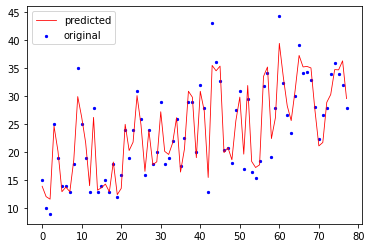

In [156]:
x_ax = range(len(test_labels))
plt.scatter(x_ax, test_labels, s=5, color="blue", label="original")
plt.plot(x_ax, ypred, lw=0.8, color="red", label="predicted")
plt.legend()
plt.show()